# EDSRx3应用

In [31]:
import math
import os
import cv2
import numpy as np
import torch
import sophon.sail as sail
import time
import os.path as osp
import tqdm
import matplotlib.pyplot as plt

## 用于前后处理的函数

In [32]:
    def img2patchs(img, patch_size=(128, 128), overlap_size=(20, 20), scale=1):#输入图像分块
        h, w, c = img.shape
        ph, pw = patch_size
        oh, ow = overlap_size
    
        r_h = (h * scale - ph * scale) % (ph * scale - oh * scale)
        r_w = (w * scale - pw * scale) % (pw * scale - ow * scale)
    
        target_w, target_h = w, h
    
        if not (h >= ph > oh and w >= pw > ow):
            return [[img]], (target_h, target_w), (0, 0)
    
        N = math.ceil((target_h - ph) / (ph - oh)) + 1
        M = math.ceil((target_w - pw) / (pw - ow)) + 1
    
        patchs_all = []
        for n in range(N):
            patchs_row = []
            for m in range(M):
    
                if n == N - 1:
                    ph_start = target_h - ph
                else:
                    ph_start = n * (ph - oh)
    
                if m == M - 1:
                    pw_start = target_w - pw
                else:
                    pw_start = m * (pw - ow)
                patch = img[ph_start:(ph_start + ph), pw_start:(pw_start + pw), :]
                patchs_row.append(patch)
            patchs_all.append(patchs_row)
    
        return patchs_all, (target_h, target_w), (r_h, r_w)
    
    
    def patchs2img(patchs, r_size, overlap_size=(20, 20)):#推理后图像合成
        N = len(patchs)
        M = len(patchs[0])
        patchs = np.array(patchs)
    
        oh, ow = overlap_size
    
        patch_shape = patchs[0][0].shape
        ph, pw = patch_shape[:2]
        r_h, r_w = r_size
    
        mode = 'GRAY' if len(patch_shape) == 2 else 'RGB'
        c = 3
    
        if N == 1 and M == 1:
            return_img = patchs[0][0]
            return return_img if mode == 'RGB' else cv2.cvtColor(return_img, cv2.COLOR_GRAY2RGB)
    
        row_imgs = []
        for n in range(N):
            row_img = patchs[n][0] if mode == 'RGB' else cv2.cvtColor(patchs[n][0], cv2.COLOR_GRAY2RGB)
            # print(row_img.shape)
            for m in range(1, M):
                if m == M - 1 and r_w != 0:
                    ow_new = pw - r_w
                else:
                    ow_new = ow
    
                patch = patchs[n][m] if mode == 'RGB' else cv2.cvtColor(patchs[n][m], cv2.COLOR_GRAY2RGB)

                h, w = row_img.shape[:2]
                new_w = w + pw - ow_new
                big_row_img = np.zeros((h, new_w, c), dtype=np.uint8)
                big_row_img[:, :w - ow_new, :] = row_img[:, :w - ow_new, :]
                big_row_img[:, w:, :] = patch[:, ow_new:, :]
                overlap_row_01 = row_img[:, w - ow_new:, :]
                overlap_row_02 = patch[:, :ow_new, :]
    
                # get weight
                weight = vertical_grad(overlap_row_01.shape, 0, 255, mode='w') / 255
                overlap_row = (overlap_row_01 * (1 - weight)).astype(np.uint8) + (overlap_row_02 * weight).astype(np.uint8)
                big_row_img[:, w - ow_new:w, :] = overlap_row
    
                row_img = big_row_img
    
            row_imgs.append(row_img)
    
        column_img = row_imgs[0]
        for i in range(1, N):
            if i == N - 1 and r_h != 0:
                oh_new = ph - r_h
            else:
                oh_new = oh
            # oh_new = oh
            row_img = row_imgs[i]
            h, w = column_img.shape[:2]
            new_h = h + ph - oh_new
            big_column_img = np.zeros((new_h, w, c), dtype=np.uint8)
            big_column_img[:h - oh_new, :, :] = column_img[:h - oh_new, :, :]
            big_column_img[h:, :, :] = row_img[oh_new:, :, :]
            overlap_column_01 = column_img[h - oh_new:, :, :]
            overlap_column_02 = row_img[:oh_new, :, :]
    
            # get weight
            weight = vertical_grad(overlap_column_01.shape, 0, 255, mode='h') / 255
            overlap_column = (overlap_column_01 * (1 - weight)).astype(np.uint8) + (overlap_column_02 * weight).astype(
                np.uint8)
            big_column_img[h - oh_new:h, :, :] = overlap_column
    
            column_img = big_column_img
    
        return column_img
    
    
    def vertical_grad(shape, color_start, color_end, mode):#合成时所需梯度
        h, w = shape[0], shape[1]
        L = h if mode == 'h' else w
    
        grad_img = np.ndarray(shape, dtype=np.uint8)
    
        # grad
        grad = float(color_end - color_start) / L
    
        for i in range(L):
            if mode == 'h':
                grad_img[i, :] = color_start + i * grad
            else:
                grad_img[:, i] = color_start + i * grad
    
        return grad_img

## 函数所需数据准备

In [33]:
rgb_range = 255  
scale = 3#超分辨率规模
engine = sail.Engine('/home/bjut1205/lcy/EDSR/EDSRx3_1684x_f32.bmodel', 0, sail.IOMode.SYSIO)
graph_name = engine.get_graph_names()[0]  # get_graph_names-test_output
overlap_size = (24, 24)
patch_size = (48, 48)
img_sr_patchs = []

## 读取一张图片对其进行前处理并对处理后的图片进行推理并存入一个二维列表

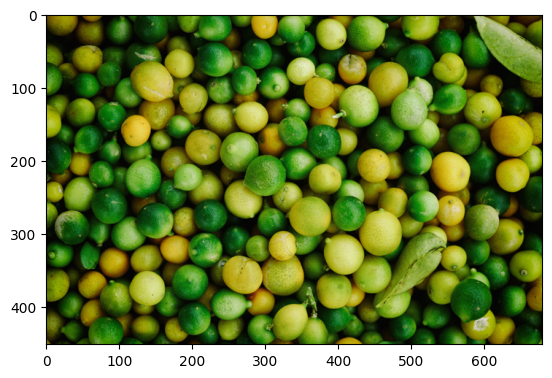

(452, 680, 3)


In [34]:
input_path = r'/home/bjut1205/lcy/DIV2K/DIV2K_train_LR_bicubic10/0002x3.png'
img = cv2.imread(input_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(img.shape)
img_patchs, _, r_size = img2patchs(img, patch_size, overlap_size)
N = len(img_patchs)
M = len(img_patchs[0])
for n in range(N):
    row_patchs = []
    for m in range(M):
        patch = img_patchs[n][m]
        img_lr = patch.transpose((2, 0, 1))  # (C, H, W)
        img_lr = np.expand_dims(img_lr, axis=0) * (255 / rgb_range)  # from np2Tensor in common.py line 53
        img_lr = np.ascontiguousarray(img_lr, dtype=np.float32)
        data_dict = {'input': img_lr}
        output = engine.process(graph_name, data_dict) 
        img_sr_patch = output['output_Conv']
        img_sr_patch = img_sr_patch.reshape(3, 144, 144)
        img_sr_patch = img_sr_patch.transpose(1, 2, 0)
        row_patchs.append(img_sr_patch)
    img_sr_patchs.append(row_patchs)
img_sr = patchs2img(img_sr_patchs, [size * 3 for size in r_size], [size * 3 for size in overlap_size])

## 将推理后的图片进行合成可视化

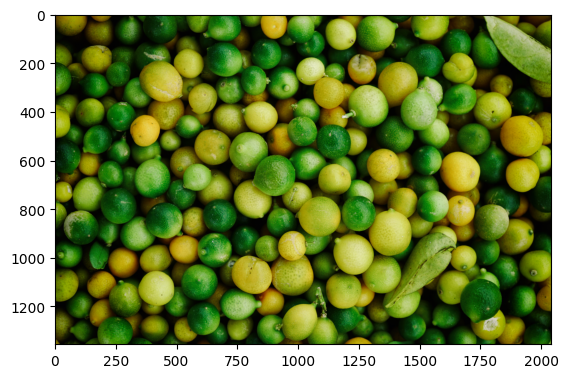

(1356, 2040, 3)


In [35]:
plt.imshow(img_sr)
plt.show()
print(img_sr.shape)